## Cодержание:
* [Импорт библиотек](#first)
* [Загрузка и изучение данных](#second)
* [Базовый анализ данных](#third)
* [Предобработка данных](#fourth)
* [Обучение модели](#fifth)
* [Тестирование модели](#sixth)
* [Выводы](#seventh)

## Импорт библиотек <a class="anchor" id="first"></a>

In [4]:
pip install pymorphy2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 845.0 kB/s eta 0:00:00--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 27.8 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [5]:
import os

import pandas as pd

from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from typing import Optional

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

import pymorphy2
from sklearn.utils import resample

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve

import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier




import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torchtext.vocab import build_vocab_from_iterator
import torch.nn.functional as F
# TorchText development is stopped and the 0.18 release (April 2024) will be the last stable release of the library.
import torchtext




import time

import re


RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


device(type='cuda', index=0)

## Загрузка данных <a class="anchor" id="second"></a>

Geo Reviews Dataset 2023 - https://github.com/yandex/geo-reviews-dataset-2023


In [6]:
df = pd.read_csv('/kaggle/input/sentimentanalysisyandexreviews/lem_500kdata.csv')

In [7]:
df

,Unnamed: 0,rating,text
0,0,3,московский квартал шумно лето ночь дикий гонка...
1,1,5,замечательный сеть магазин общий хороший ассор...
2,2,1,знать смутить коготь дать правило удивить хоте...
3,3,4,хороший условие аренда дружелюбный персонално ...
4,4,5,топ мастер ангелина топ смысл немного волноват...
...,...,...,...
498824,499994,5,хороший способ избежать автобусный пытка элект...
498825,499995,4,охрана кривая добрый дверь закрываться автомат...
498826,499996,4,сравнение многий современный платформа эпоха с...
498827,499998,5,семья отличный место рекомендовать это настоящ...


## Подготовка данных для обучения модели

### Баланс классов

У нас большой датасет и минорный класс имеет `2` имеет 12071 отзыв, так что я возьму у каждого класса по 50000 отызвов.

In [8]:
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct


def get_plt_value_counts(Series: pd.Series) -> None:

    value_counts = Series.value_counts()

    plt.figure(figsize=(4, 4))
    plt.pie(value_counts, labels=value_counts.index,
            autopct=make_autopct(value_counts), startangle=30)
    plt.axis('equal')
    plt.title('Распределение отзывов по оценке')

    plt.show()


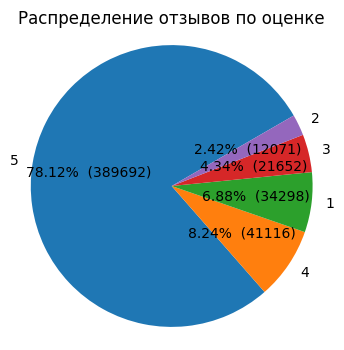

In [9]:
get_plt_value_counts(df['rating'])

In [10]:
def get_balanced_df(df: pd.DataFrame, size) -> pd.DataFrame:
    class_1 = df[df['rating'] == 1]
    class_2 = df[df['rating'] == 2]
    class_3 = df[df['rating'] == 3]
    class_4 = df[df['rating'] == 4]
    class_5 = df[df['rating'] == 5]

    class_1_undersampled = resample(class_1, replace=True, n_samples=size)
    class_2_undersampled = resample(class_2, replace=True, n_samples=size)
    class_3_undersampled = resample(class_3, replace=True, n_samples=size)
    class_4_undersampled = resample(class_4, replace=True, n_samples=size)
    class_5_undersampled = resample(class_5, replace=False, n_samples=size)

    new_df = pd.concat([class_1_undersampled, class_2_undersampled,class_3_undersampled, class_4_undersampled, class_5_undersampled])
    return new_df['text'], new_df['rating']

### Делим выборку на train и test

In [11]:
df['text'] = df['text'].fillna('')
df['rating'] = df['rating'].fillna('')

X = df['text']
y = df['rating']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


X_train_b, y_train_b = get_balanced_df(pd.concat([X_train, y_train], axis=1), 50000)

Делим выборку перед векторизацией, что бы избежать утечки данных при тесте.

### Векторизация

Я пробывал два способа векторизации. tfidf - обучался быстрее и показывал лучше точность. 

Здесь я использую параметры: 
1. min_df= 1  - я хотел убрать редко встречаемые слова и слова написаные с ошибкой, чтобы повысило точность модели. И оно повысилось. Но если мы ставим 1 с ngram_range=(1, 3) работает отлично.
2. max_df=0.95 - здесь беру слова которые в 95% документах, избавляюсь от частых слов.
3. ngram_range=(1, 3) - для учета словосочетаний.

In [16]:
def get_tfidf_vectorized(X_train,X_test) -> tuple[pd.Series, pd.Series]:
    tfidf_vectorizer = TfidfVectorizer(
#         min_df=1,
         binary=False, max_features=12000)

    X_train.fillna('', inplace=True)
    X_test.fillna('', inplace=True)


    X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

    X_test_tfidf = tfidf_vectorizer.transform(X_test)

    return X_train_tfidf, X_test_tfidf


In [17]:
X_train_tfidf, X_test_tfidf = get_tfidf_vectorized(X_train, X_test)

print('Tfidf_train:', X_train_tfidf.shape)
print('Tfidf_test:', X_test_tfidf.shape)

Tfidf_train: (399063, 12000)
Tfidf_test: (99766, 12000)


In [18]:
X_train_b_tfidf, X_test_tfidf = get_tfidf_vectorized(X_train_b, X_test)

print('Tfidf_train:', X_train_b_tfidf.shape)
print('Tfidf_test:', X_test_tfidf.shape)

Tfidf_train: (250000, 12000)
Tfidf_test: (99766, 12000)


### Dataloader

In [19]:
class WordDataset:
    def __init__(self, text, label, token2inx, maxlen=256):
        self.text = text
        self.label = label

        self.token2inx = token2inx
        self.maxlen = maxlen


        self.unk_id = token2inx['<unk>']
        self.pad_id = token2inx['<pad>']

    def __getitem__(self, index):

        processed_text = self.text[index].split()
        tokenized_sentence = [
            self.token2inx.get(word, self.unk_id) for word in processed_text
        ]

        tokenized_sentence = tokenized_sentence[:self.maxlen]

        # Добавление padding, если длина последовательности меньше maxlen
        pad_length = self.maxlen - len(tokenized_sentence)
        tokenized_sentence += [self.pad_id] * pad_length

        train_sample = {"text" : torch.tensor(tokenized_sentence, dtype=torch.long).to(device) ,"label": torch.tensor(self.label[index], dtype=torch.long).to(device)}

        return train_sample

    def __len__(self) -> int:
        return len(self.text)



In [20]:
def yield_tokens(text):
    for line in text:
        yield line.strip().split()

# Disbalanced
vocab = build_vocab_from_iterator(yield_tokens(X_train), specials=["<unk>", "<pad>"])
token2inx = vocab.get_stoi()
inx2token = {inx: token for token, inx in vocab.get_stoi().items()}

# Balanced
vocab_b = build_vocab_from_iterator(yield_tokens(X_train_b), specials=["<unk>", "<pad>"])
token2inx_b = vocab_b.get_stoi()
inx2token_b = {inx: token for token, inx in vocab_b.get_stoi().items()}

In [21]:
len(token2inx), len(token2inx_b)

(400076, 194865)

In [22]:
train_dataset = WordDataset(X_train.values, y_train.values - 1, token2inx)
train_dataset_b = WordDataset(X_train_b.values, y_train_b.values - 1, token2inx_b)

test_dataset = WordDataset(X_test, y_test, token2inx)


train_dataloader = DataLoader(train_dataset,  batch_size=16)
train_dataloader_b = DataLoader(train_dataset_b,  batch_size=16, shuffle=True)


test_dataloader = DataLoader(test_dataset, batch_size=256)

## Обучение моделей <a class="anchor" id="fifth"></a>

### Функции обучения

In [ ]:
def get_confusion_matrix(y_test, y_pred):
    confusion = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues",
                xticklabels=[1, 2, 3, 4, 5],
                yticklabels=[1, 2, 3, 4, 5])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

In [23]:
def train_ml(model, X_train, y_train, X_test, y_test):
    start_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time

    start_time = time.time()
    y_pred = model.predict(X_test)
    test_time = time.time() - start_time

    cr = classification_report(y_test, y_pred)
    print(f"Training_time : {training_time}")
    print(f"Test_time : {test_time}")

    print(cr)
    get_confusion_matrix(y_test, y_pred)


In [24]:
def train_dl(model, optimizer, criterion, n_epochs, train_loader, test_loader):

    loss_train = []
    accuracy_train = []

    for epoch in range(n_epochs):
        model.train()  # для трейна модели ставим ее в train()
        for batch in tqdm(train_loader, desc=f'Training epoch {epoch + 1}:'):
          texts = batch['text']
          labels = batch['label']
          output = model(texts)
          loss = criterion(output, labels)

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

        model.eval()  # для теста модели ставим ее в eval()

        correct = 0
        total = 0

        with torch.no_grad():
            for texts, labels in test_loader:

              texts = batch['text']
              labels = batch['label']
              output = model(texts)
              _, predicted = torch.max(output.data, 1)
              total += labels.size(0)
              correct += (predicted == labels).sum().item()

        test_accuracy = correct / total
        accuracy_train.append(test_accuracy)

        print('Epoch [{}/{}], Loss: {:.4f}, Test Accuracy: {:.2f}%'.format(
            epoch + 1, n_epochs, loss.item(), test_accuracy * 100))
        loss_train.append(loss.item())

In [71]:
results_df = pd.DataFrame(columns=["Model", "Run time", "Training time", "Test time", "Accuracy", "Cross-Validation Accuracy"])

### Запуск обучения

MultinomialNB

In [18]:
X_test_tfidf

<99766x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 2421496 stored elements in Compressed Sparse Row format>

Training_time : 0.07430410385131836
Test_time : 0.01638174057006836
              precision    recall  f1-score   support

           1       0.52      0.67      0.58      6822
           2       0.16      0.29      0.21      2367
           3       0.23      0.30      0.26      4365
           4       0.21      0.58      0.31      8273
           5       0.97      0.72      0.83     77939

    accuracy                           0.68     99766
   macro avg       0.42      0.51      0.44     99766
weighted avg       0.83      0.68      0.73     99766



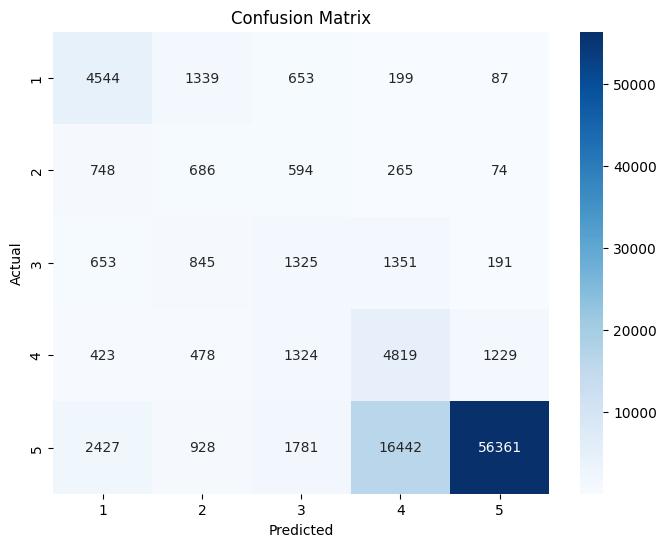

In [19]:
naive_bayes = MultinomialNB()


train_ml(naive_bayes, X_train_b_tfidf, y_train_b, X_test_tfidf, y_test)

LogisticRegression

Training_time : 10.07732629776001
Test_time : 0.016765594482421875
              precision    recall  f1-score   support

           1       0.64      0.67      0.65      6822
           2       0.16      0.32      0.21      2367
           3       0.22      0.34      0.27      4365
           4       0.25      0.52      0.34      8273
           5       0.97      0.80      0.88     77939

    accuracy                           0.73     99766
   macro avg       0.45      0.53      0.47     99766
weighted avg       0.84      0.73      0.77     99766



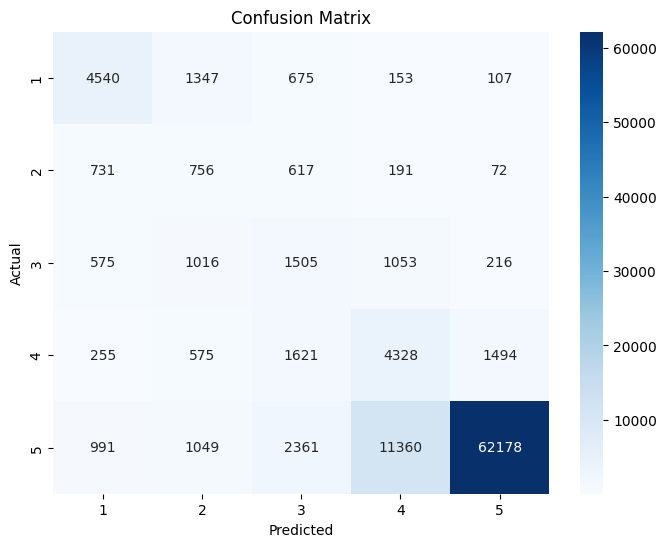

In [20]:
logistic_classifier = LogisticRegression(
    solver='saga',
    max_iter=1000,
    multi_class='multinomial',
    penalty='l2',
    C=1.0,
    random_state=42
)



train_ml(logistic_classifier, X_train_b_tfidf, y_train_b, X_test_tfidf, y_test)

RandomForestClassifier

Training_time : 206.32306694984436
Test_time : 1.7045550346374512
              precision    recall  f1-score   support

           1       0.47      0.81      0.59      6822
           2       0.14      0.06      0.09      2367
           3       0.19      0.22      0.21      4365
           4       0.24      0.49      0.33      8273
           5       0.95      0.80      0.87     77939

    accuracy                           0.73     99766
   macro avg       0.40      0.48      0.42     99766
weighted avg       0.81      0.73      0.75     99766



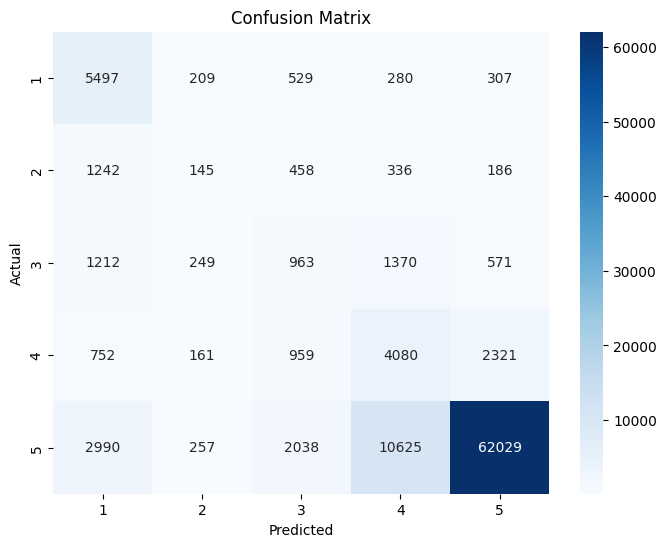

In [21]:
random_forest = RandomForestClassifier(
    n_estimators=40,
    criterion='gini',
    max_depth=None,
    min_samples_split=5,
    min_samples_leaf=5,
    random_state=42
)

train_ml(random_forest, X_train_b_tfidf, y_train_b, X_test_tfidf, y_test)

CatBoostClassifier

In [10]:
def train_catboost(model: CatBoostClassifier,
                   X_train: pd.DataFrame, y_train: pd.Series,
                   X_test: pd.DataFrame, y_test: pd.Series,
                   model_name: str,
                   verbose_step: int = 100) -> pd.DataFrame:

    start_time = time.time()
    model.fit(
        X_train, y_train,                   # обучающая выборка
        eval_set=(X_test, y_test),            # тестовая выборка
        verbose=verbose_step                         # шаг вывода статуса модели
    )
    training_time = time.time() - start_time

    model.save_model(f'{model_name}.json')
    feature_importance = model.get_feature_importance(prettified=True)

    start_time = time.time()
    y_pred = model.predict(X_test)
    test_time = time.time() - start_time

    cr = classification_report(y_test, y_pred)
    print(f"Training_time : {training_time}")
    print(f"Test_time : {test_time}")

    print(cr)
    get_confusion_matrix(y_test, y_pred)

0:	learn: 1.5810681	test: 1.5564084	best: 1.5564084 (0)	total: 1.47s	remaining: 24m 24s
100:	learn: 1.1908488	test: 0.9960287	best: 0.9960287 (100)	total: 1m 59s	remaining: 17m 46s
200:	learn: 1.1020631	test: 0.9040702	best: 0.9040702 (200)	total: 3m 47s	remaining: 15m 2s
300:	learn: 1.0481101	test: 0.8602625	best: 0.8602625 (300)	total: 5m 31s	remaining: 12m 50s
400:	learn: 1.0094672	test: 0.8338400	best: 0.8338400 (400)	total: 7m 14s	remaining: 10m 48s
500:	learn: 0.9782754	test: 0.8157781	best: 0.8157781 (500)	total: 8m 54s	remaining: 8m 52s
600:	learn: 0.9522941	test: 0.8020090	best: 0.8020090 (600)	total: 10m 33s	remaining: 7m
700:	learn: 0.9292843	test: 0.7916004	best: 0.7916004 (700)	total: 12m 12s	remaining: 5m 12s
800:	learn: 0.9101875	test: 0.7832225	best: 0.7832225 (800)	total: 13m 48s	remaining: 3m 25s
900:	learn: 0.8930259	test: 0.7757555	best: 0.7757555 (900)	total: 15m 24s	remaining: 1m 41s
999:	learn: 0.8773705	test: 0.7690627	best: 0.7690627 (999)	total: 16m 58s	remain

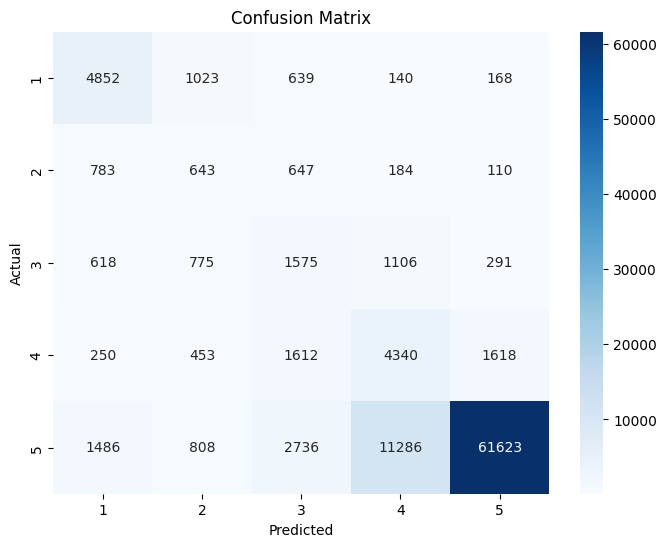

In [22]:
# архитектура модели
catboost_model = CatBoostClassifier(
    iterations=1000,            # кол-во итераций обучения
    depth=6,                    # рекомендованная глубина модели
    learning_rate=0.075,        # скорость обучения
    random_seed=47,             # сид для воспроизводимости результата
    loss_function='MultiClass', # тип модели или функция ошибки
    task_type="GPU",            # обучение на видеокарте
    devices='0',
    early_stopping_rounds=20    # регуляризация ранней остановкой в случае
    )


train_catboost(catboost_model, X_train_b_tfidf, y_train_b, X_test_tfidf, y_test, model_name = 'catboost_model')

LGBMClassifier

In [ ]:
lgbm_model = lgbm.LGBMClassifier(device="gpu",
                            max_bin = 63,
                        num_leaves = 255,
                        num_iterations = 500,
                        learning_rate = 0.01,
                        tree_learner = 'serial',
                        task = 'train',
                        is_training_metric = False,
                        min_data_in_leaf = 1,
                        min_sum_hessian_in_leaf = 100,
                        sparse_threshold=1.0,
                        device = 'gpu',
                        num_thread = -1,
                        save_binary= True,
                        seed= 42,
                        feature_fraction_seed = 42,
                        bagging_seed = 42,
                        drop_seed = 42,
                        data_random_seed = 42,
                        objective = 'binary',
                        boosting_type = 'gbdt',
                        verbose = 1,
                        metric = 'auc',
                        is_unbalance = True,
                        boost_from_average = False)


train_catboost(lgbm_model, X_train_b_tfidf, y_train_b, X_test_tfidf, y_test, model_name = 'lgbm_model_model')

XGBClassifier

In [ ]:
xgb = xgb.XGBClassifier(n_estimators=1000,
                                  max_depth=5,
                                  learning_rate=0.1,
                                  subsample=0.7,
                                  colsample_bytree=0.8,
                                  colsample_bylevel=0.8,
                                  tree_method='gpu_hist',
                                  random_state=42, seed=42)

In [ ]:
y_train_xgb = y_train - 1
y_test_xgb = y_test - 1

model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=5,
    max_depth=6,
    subsample=0.8,
    n_estimators=20,
    random_state=42
)

start_time = time.time()
model.fit(X_train_tfidf, y_train_xgb)
training_time = time.time() - start_time
y_pred = model.predict(X_test_tfidf)
test_time = time.time() - start_time
accuracy_xgb = accuracy_score(y_test_xgb, y_pred)
results_df = results_df.append({
    "Model": "XGBClassifier",
    "Run time": test_time,
    "Training time": training_time,
    "Test time": test_time - training_time,
    "Accuracy": accuracy_xgb
}, ignore_index=True)

Вывод: результаты средние. Для лучшего скора идем в DL.

RNN

Вывод: могу сказать, что тут еще много работать. Есть переобучение. Думаю нужно больше данных и использовать другие методы обучения, которые требуют больших вычислительных затрат. К сожалению, я затянул со сдачей работы и не имею столько времени. Я бы продолжил работу над этим датасетом в в будущем. Лучшая модель - Логистическая регресия в моей случае. Есть сложность в определении 2,3,4 - думаю из-за этого и переобучение. Также есть идея в в лучшей обработке данных, убрать лишнии признаки как я и хотел, что возможно для другой модели дасть лучший результат.

## Проверка отзывов

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('russian'))

morph = MorphAnalyzer()


def pr_sentiment(text):
    original_text = text
    text = text.lower()
    text = re.sub(r'[^а-яА-Я ]', '', text)
    text = re.sub('\s+[a-zA-Z]\s+', '', text)
    text = word_tokenize(text, language='russian')
    text = ' '.join(text)

    text = [word for word in text.split() if word not in stop_words]

    lemmatized_words = [morph.parse(word)[0].normal_form for word in text]
    lemmatized_text = " ".join(lemmatized_words)

    review = tfidf_vectorizer.transform([lemmatized_text])
    y_review = logistic_classifier.predict(review)
    print(original_text , y_review)

review = analyze_sentiment("Отличное место")

review = analyze_sentiment("Ужасное место")

review = analyze_sentiment("Неплохое место")

review = analyze_sentiment("Плохое место")

review = analyze_sentiment("Плохое место, но кухня хорошая")

review = analyze_sentiment("Плохое место, но кухня хорошая, офицант нахамил, место грязное")

review = analyze_sentiment("Парк красивый, но очень страшно тут когда темно")

review = analyze_sentiment("Море теплое, отель хороший. Много грязи.")

review = analyze_sentiment("Море теплое, отель не очень. Много грязи. Отель старый, но жить можно.")

review = analyze_sentiment("Море теплое, отель не очень. Много грязи. Отель старый, но жить можно.")